In [1]:
import io
import ipywidgets as widgets
from math import cos, degrees, radians, pi
import geopandas
import requests
import pandas as pd

from tqdm import trange
from tqdm import tqdm
from PIL import Image
from owslib.wms import WebMapService
from owslib.wfs import WebFeatureService
from owslib.wmts import WebMapTileService
from pyproj import CRS, Transformer
from owslib.etree import etree
from owslib.util import testXMLValue
from owslib.wmts import TileMatrixSet, TileMatrix

# Calcul de la position d'une tuile WMTS


Ressources : 

- [Carte interactive](https://www.geoportail.gouv.fr/carte)
- [Documentation WMTS](https://geoservices.ign.fr/documentation/services/api-et-services-ogc/images-tuilees-wmts-ogc)

# Récupération de la table d'échelles

In [2]:
WMTS_SERVICE_URL = "https://wxs.ign.fr/satellite/geoportail/wmts"

wmts = WebMapTileService(WMTS_SERVICE_URL, version='1.0.0')
wmts.identification.title

'Service de visualisation WMTS Geoportail Publics'

In [3]:
PM_MATRIX_SET: TileMatrixSet = wmts.tilematrixsets["PM"]

In [4]:
def convert_coordinates(longitude: float, latitude: float):
    gps_crs = CRS("EPSG:4326")
    mercator_crs = CRS("EPSG:3857")
    coordinates_transformer = Transformer.from_crs(gps_crs, mercator_crs, always_xy=True)
    x, y = coordinates_transformer.transform(longitude, latitude)
    return x, y

def compute_tile_position(matrix_set: TileMatrixSet, zoom_level: int, longitude: float, latitude: float):
    # TileMatrixSet.tilematrix is a dictionnary containing the matrices !
    matrix_set_dict: dict[str, TileMatrix] = matrix_set.tilematrix
    target_matrix = matrix_set_dict[str(zoom_level)]
    tile_width_meters = target_matrix.scaledenominator * 0.00028 * 256
    print(f"Tile width in meters : {tile_width_meters}")
    x0, y0 = map(lambda x: float(x), target_matrix.topleftcorner)
    x, y = convert_coordinates(longitude=longitude, latitude=latitude)
    print(f"X = {x}, Y = {y}, identifier = {target_matrix.identifier}")
    tile_col, tile_row  = (x - x0) / tile_width_meters, (y0 - y) / tile_width_meters
    tile_col, tile_row = int(round(tile_col, 0)), int(round(tile_row, 0))
    return tile_row, tile_col

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def get_concat_image(image_grid):
    # total_width = sum([img.width for img in image_grid[0]])
    # total_height = sum([img.height for img in image_grid])
    total_width = 256 * len(image_grid[0]) 
    total_height = 256 * len(image_grid)
    dst = Image.new('RGB', (total_width, total_height))
    for i in range(len(image_grid[0])):
        for j in range(len(image_grid)):
            dst.paste(image_grid[i][j], (j*256, i*256))
    return dst
    
def identify_coordinates(address):
    """This functions performs an API call with the scrapped address of the restaurant to the OpenStreetMap API.
    A longitude and a latitude are then returned."""
    


    target_url = 'https://nominatim.openstreetmap.org/search?q=' + address + '&format=json'
        
    target_url = target_url.replace(',', '%2C')
    target_url = target_url.replace(' ', '+')

    r = requests.get(target_url)
    found_coordinates = True
    if r.status_code == 200:
        try:
            coordinates = r.json()[0]
            latitude, longitude = coordinates['lat'], coordinates['lon']
            
        except:
            print(f'Address not found for: {target_url}')
            latitude, longitude = None, None
            found_coordinates = False
            
    else:
        print(f'Error {r.status_code} ocurred on the request')
        latitude, longitude, found_coordinates = None, None, False
    return latitude, longitude, found_coordinates 

In [5]:
correspondance_table = pd.read_html("https://developers.arcgis.com/documentation/mapping-apis-and-services/reference/zoom-levels-and-scale/")[0]
correspondance_table["Usage suggestion"] = correspondance_table["Usage suggestion"].fillna(method='ffill')
correspondance_table["New legend"] = correspondance_table["Zoom level"].astype(str) + \
                                    " - " + correspondance_table["Scale"].astype(str) + " - " + correspondance_table["Usage suggestion"]
correspondance_table = correspondance_table.set_index("Zoom level")
available_zoom_levels = list(set(correspondance_table.index).intersection(set([int(key) for key in PM_MATRIX_SET.tilematrix.keys()])))
correspondance_table = correspondance_table.iloc[available_zoom_levels].sort_index()
available_options = correspondance_table.loc[:, "New legend"].to_list()

In [6]:
zoom_level_widget = widgets.Dropdown(
    options=available_options,
    value=available_options[0],
    description='Zooming level'
)
latitude_widget = widgets.BoundedFloatText(
    value=48.858007,
    description='Latitude',
)
longitude_widget = widgets.BoundedFloatText(
    value=2.294535,
    description='Longitude',
)
layer_widget = widgets.Dropdown(
    options=wmts.contents.keys(),
    # value=0,
    description='Layer'
)

In [7]:
display(zoom_level_widget)
display(latitude_widget)
display(longitude_widget)
display(layer_widget)

Dropdown(description='Zooming level', options=('0 - 591657527.591555 - Global', '1 - 295828763.795777 - Global…

BoundedFloatText(value=48.858007, description='Latitude')

BoundedFloatText(value=2.294535, description='Longitude')

Dropdown(description='Layer', options=('ORTHOIMAGERY.ORTHO-SAT.PLEIADES.2012', 'ORTHOIMAGERY.ORTHO-SAT.PLEIADE…

In [8]:
ZOOM_LEVEL = int(zoom_level_widget.value[:2])
LATITUDE = latitude_widget.value
LONGITUDE = longitude_widget.value
LAYER = layer_widget.value

# WMTS analysis

In [9]:
matrix_set = wmts.tilematrixsets["PM"]
tile_row, tile_column = compute_tile_position(matrix_set, ZOOM_LEVEL, LONGITUDE, LATITUDE)
print(f"Tile row nb: {tile_row}, Tile column nb:{tile_column}")

Tile width in meters : 39135.75848201024
X = 255426.467807344, Y = 6250802.406705633, identifier = 10
Tile row nb: 352, Tile column nb:519


In [10]:
image_grid = [[] for i in range(0, 3)]
for i, row in enumerate(trange(tile_row-1, tile_row+2)):
    for j, col in enumerate(range(tile_column-1, tile_column+2)):
        request = wmts.gettile(layer=LAYER,
                tilematrixset="PM", 
                tilematrix=ZOOM_LEVEL, 
                row=row,
                column=col)
        image_grid[i].append(Image.open(io.BytesIO(request.read())))

100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


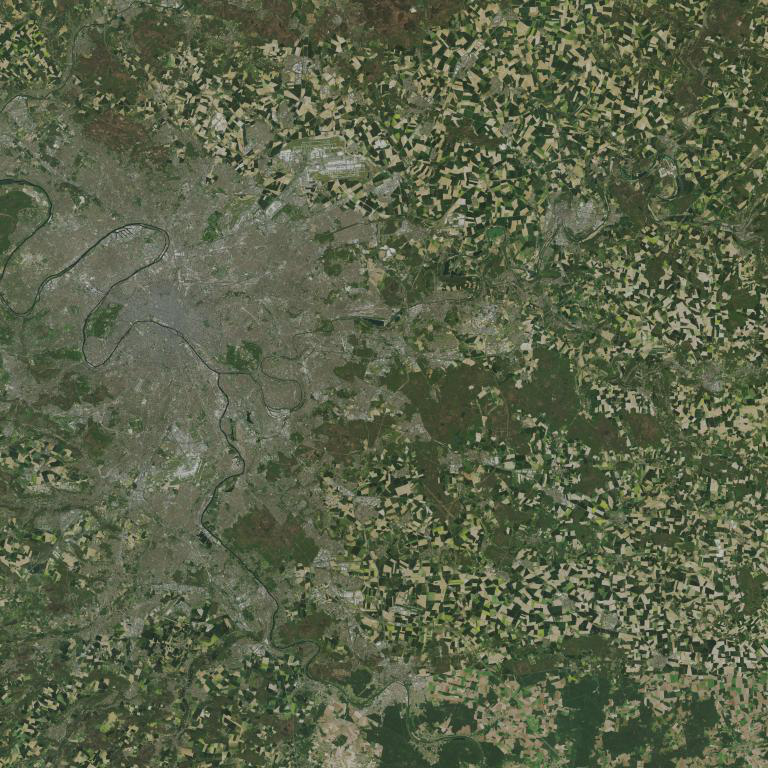

In [11]:
dst = get_concat_image(image_grid)
display(dst)

In [68]:
# zoom_level = 14
# C = 2*pi * 6_378_137.000
# nb_tiles = 2**(2*zoom_level)
# nb_tiles
# tile_width = 360/(2**zoom_level)
# tile_width * 113.32 * 1000
# tile_width_meter = (C * (cos(radians(LATITUDE))) ) / (2**(zoom_level+8))
# tile_width_meter
# zoom_level = identifier
# # zoom_level = int(identifier)
# horizontal_tile_distance = (C * cos(radians(LATITUDE)) ) / (2 ** zoom_level)
# ((2 * pi * 6371 * 1000 * tile_width)/360)/256

In [ ]:
# Version XML

# Extracts capabilities
# capabilities = etree.fromstring(wmts.getServiceXML())
# Extracts contents
# caps = capabilities.find(_CONTENTS_TAG)
# tl = testXMLValue(elem.find(_TOP_LEFT_CORNER_TAG))
# print(tl)

# Extracts Tile Matrix Sets
# tilematrixsets = {}
# for elem in caps.findall(_TILE_MATRIX_SET_TAG):
#     print(testXMLValue(elem.find(_IDENTIFIER_TAG)).strip())
    # print(elem.find(_TOP_LEFT_CORNER_TAG))
    # tms = TileMatrixSet(elem)
    # if tms.identifier:
    #     if tms.identifier in tilematrixsets:
    #         raise KeyError('TileMatrixSet with identifier "%s" '
    #                         'already exists' % tms.identifier)
    #     tilematrixsets[tms.identifier] = tms

# tilematrixsets

In [283]:
# HARDCODED_METERS_PER_PIXEL = 0.5971642835
# pm_matrix_set = [matrix_set for matrix_set in caps.findall(_TILE_MATRIX_SET_TAG) if matrix_set.find(_IDENTIFIER_TAG).text.strip() == "PM"][0]
# pm_matrix_set
# scale_range = range(SCALE-5, SCALE+6)
# target_matrix = [matrix for matrix in pm_matrix_set.findall(_TILE_MATRIX_TAG) if int(float(matrix.find(_SCALE_DENOMINATOR_TAG).text)) in scale_range][0]
# target_top_corner = target_matrix.find(_TOP_LEFT_CORNER_TAG).text.split()
# target_identifier = int(target_matrix.find(_IDENTIFIER_TAG).text)
# target_height = int(target_matrix.find(_TILE_HEIGHT_TAG).text)
# target_width = int(target_matrix.find(_TILE_WIDTH_TAG).text)
# tile_meter_length = target_height * HARDCODED_METERS_PER_PIXEL
# x0, y0 = map(lambda x: float(x), target_top_corner)
# x0, y0
# tile_meter_length

# WMS analysis

In [3]:
wms = WebMapService(WMS_SERVICE_URL, version='1.3.0')
wms.identification.title

'Service WMS Raster Geoportail Publics'

In [4]:
print(wms.getOperationByName('GetMap').methods)
print(wms.getOperationByName('GetMap').formatOptions)

[{'type': 'Get', 'url': 'https://wxs.ign.fr/satellite/geoportail/r/wms?'}]
['image/jpeg', 'image/png', 'image/tiff', 'image/geotiff', 'image/x-bil;bits=32', 'text/asc']


In [5]:
list(wms.contents)

['ORTHOIMAGERY.ORTHO-SAT.PLEIADES.2012',
 'ORTHOIMAGERY.ORTHO-SAT.PLEIADES.2013',
 'ORTHOIMAGERY.ORTHO-SAT.PLEIADES.2014',
 'ORTHOIMAGERY.ORTHO-SAT.PLEIADES.2015',
 'ORTHOIMAGERY.ORTHO-SAT.PLEIADES.2016',
 'ORTHOIMAGERY.ORTHO-SAT.PLEIADES.2017',
 'ORTHOIMAGERY.ORTHO-SAT.PLEIADES.2018',
 'ORTHOIMAGERY.ORTHO-SAT.PLEIADES.2019',
 'ORTHOIMAGERY.ORTHO-SAT.PLEIADES.2020',
 'ORTHOIMAGERY.ORTHO-SAT.PLEIADES.2021',
 'ORTHOIMAGERY.ORTHO-SAT.PLEIADES.2022',
 'ORTHOIMAGERY.ORTHO-SAT.RAPIDEYE.2010',
 'ORTHOIMAGERY.ORTHO-SAT.RAPIDEYE.2011',
 'ORTHOIMAGERY.ORTHO-SAT.SPOT.2013',
 'ORTHOIMAGERY.ORTHO-SAT.SPOT.2014',
 'ORTHOIMAGERY.ORTHO-SAT.SPOT.2015',
 'ORTHOIMAGERY.ORTHO-SAT.SPOT.2016',
 'ORTHOIMAGERY.ORTHO-SAT.SPOT.2017',
 'ORTHOIMAGERY.ORTHO-SAT.SPOT.2018',
 'ORTHOIMAGERY.ORTHO-SAT.SPOT.2019',
 'ORTHOIMAGERY.ORTHO-SAT.SPOT.2020',
 'ORTHOIMAGERY.ORTHO-SAT.SPOT.2021']

In [6]:
layer = wms['ORTHOIMAGERY.ORTHO-SAT.SPOT.2021']
print(layer.crsOptions)
print(layer.styles)
print(layer.boundingBox[0:4])


['EPSG:4627', 'EPSG:27574', 'EPSG:4275', 'IGNF:UTM22RGFG95', 'IGNF:LAMB4', 'IGNF:LAMB3', 'IGNF:RGF93G', 'EPSG:32705', 'IGNF:TAHI51UTM06S', 'IGNF:STPM50GEO', 'EPSG:4559', 'EPSG:4637', 'EPSG:4638', 'EPSG:32739', 'EPSG:2981', 'EPSG:3302', 'EPSG:27592', 'EPSG:3949', 'EPSG:2989', 'EPSG:4639', 'IGNF:RGPFUTM7S', 'IGNF:RGR92UTM40S', 'IGNF:UTM32W84', 'EPSG:23030', 'EPSG:4636', 'IGNF:RGF93CC45', 'EPSG:27564', 'IGNF:STPM50UTM21', 'IGNF:RGM04UTM38S', 'EPSG:4688', 'EPSG:4692', 'IGNF:CSG67GEO', 'EPSG:32738', 'EPSG:3303', 'EPSG:4687', 'IGNF:CSG67UTM22', 'EPSG:4467', 'EPSG:2988', 'EPSG:4471', 'EPSG:2975', 'IGNF:MART38GEO', 'IGNF:RGF93CC49', 'EPSG:3944', 'IGNF:UTM20W84MART', 'EPSG:2970', 'EPSG:3943', 'EPSG:3172', 'EPSG:2973', 'EPSG:3298', 'EPSG:27572', 'EPSG:27583', 'IGNF:MAYO50GEO', 'EPSG:4690', 'EPSG:32701', 'EPSG:2978', 'IGNF:UTM31W84', 'EPSG:4644', 'IGNF:UTM01SW84', 'EPSG:4628', 'EPSG:32707', 'IGNF:RGF93CC42', 'IGNF:GUADFM49GEO', 'EPSG:4689', 'IGNF:WGS84UTM20', 'EPSG:3946', 'EPSG:3304', 'EPSG:32630

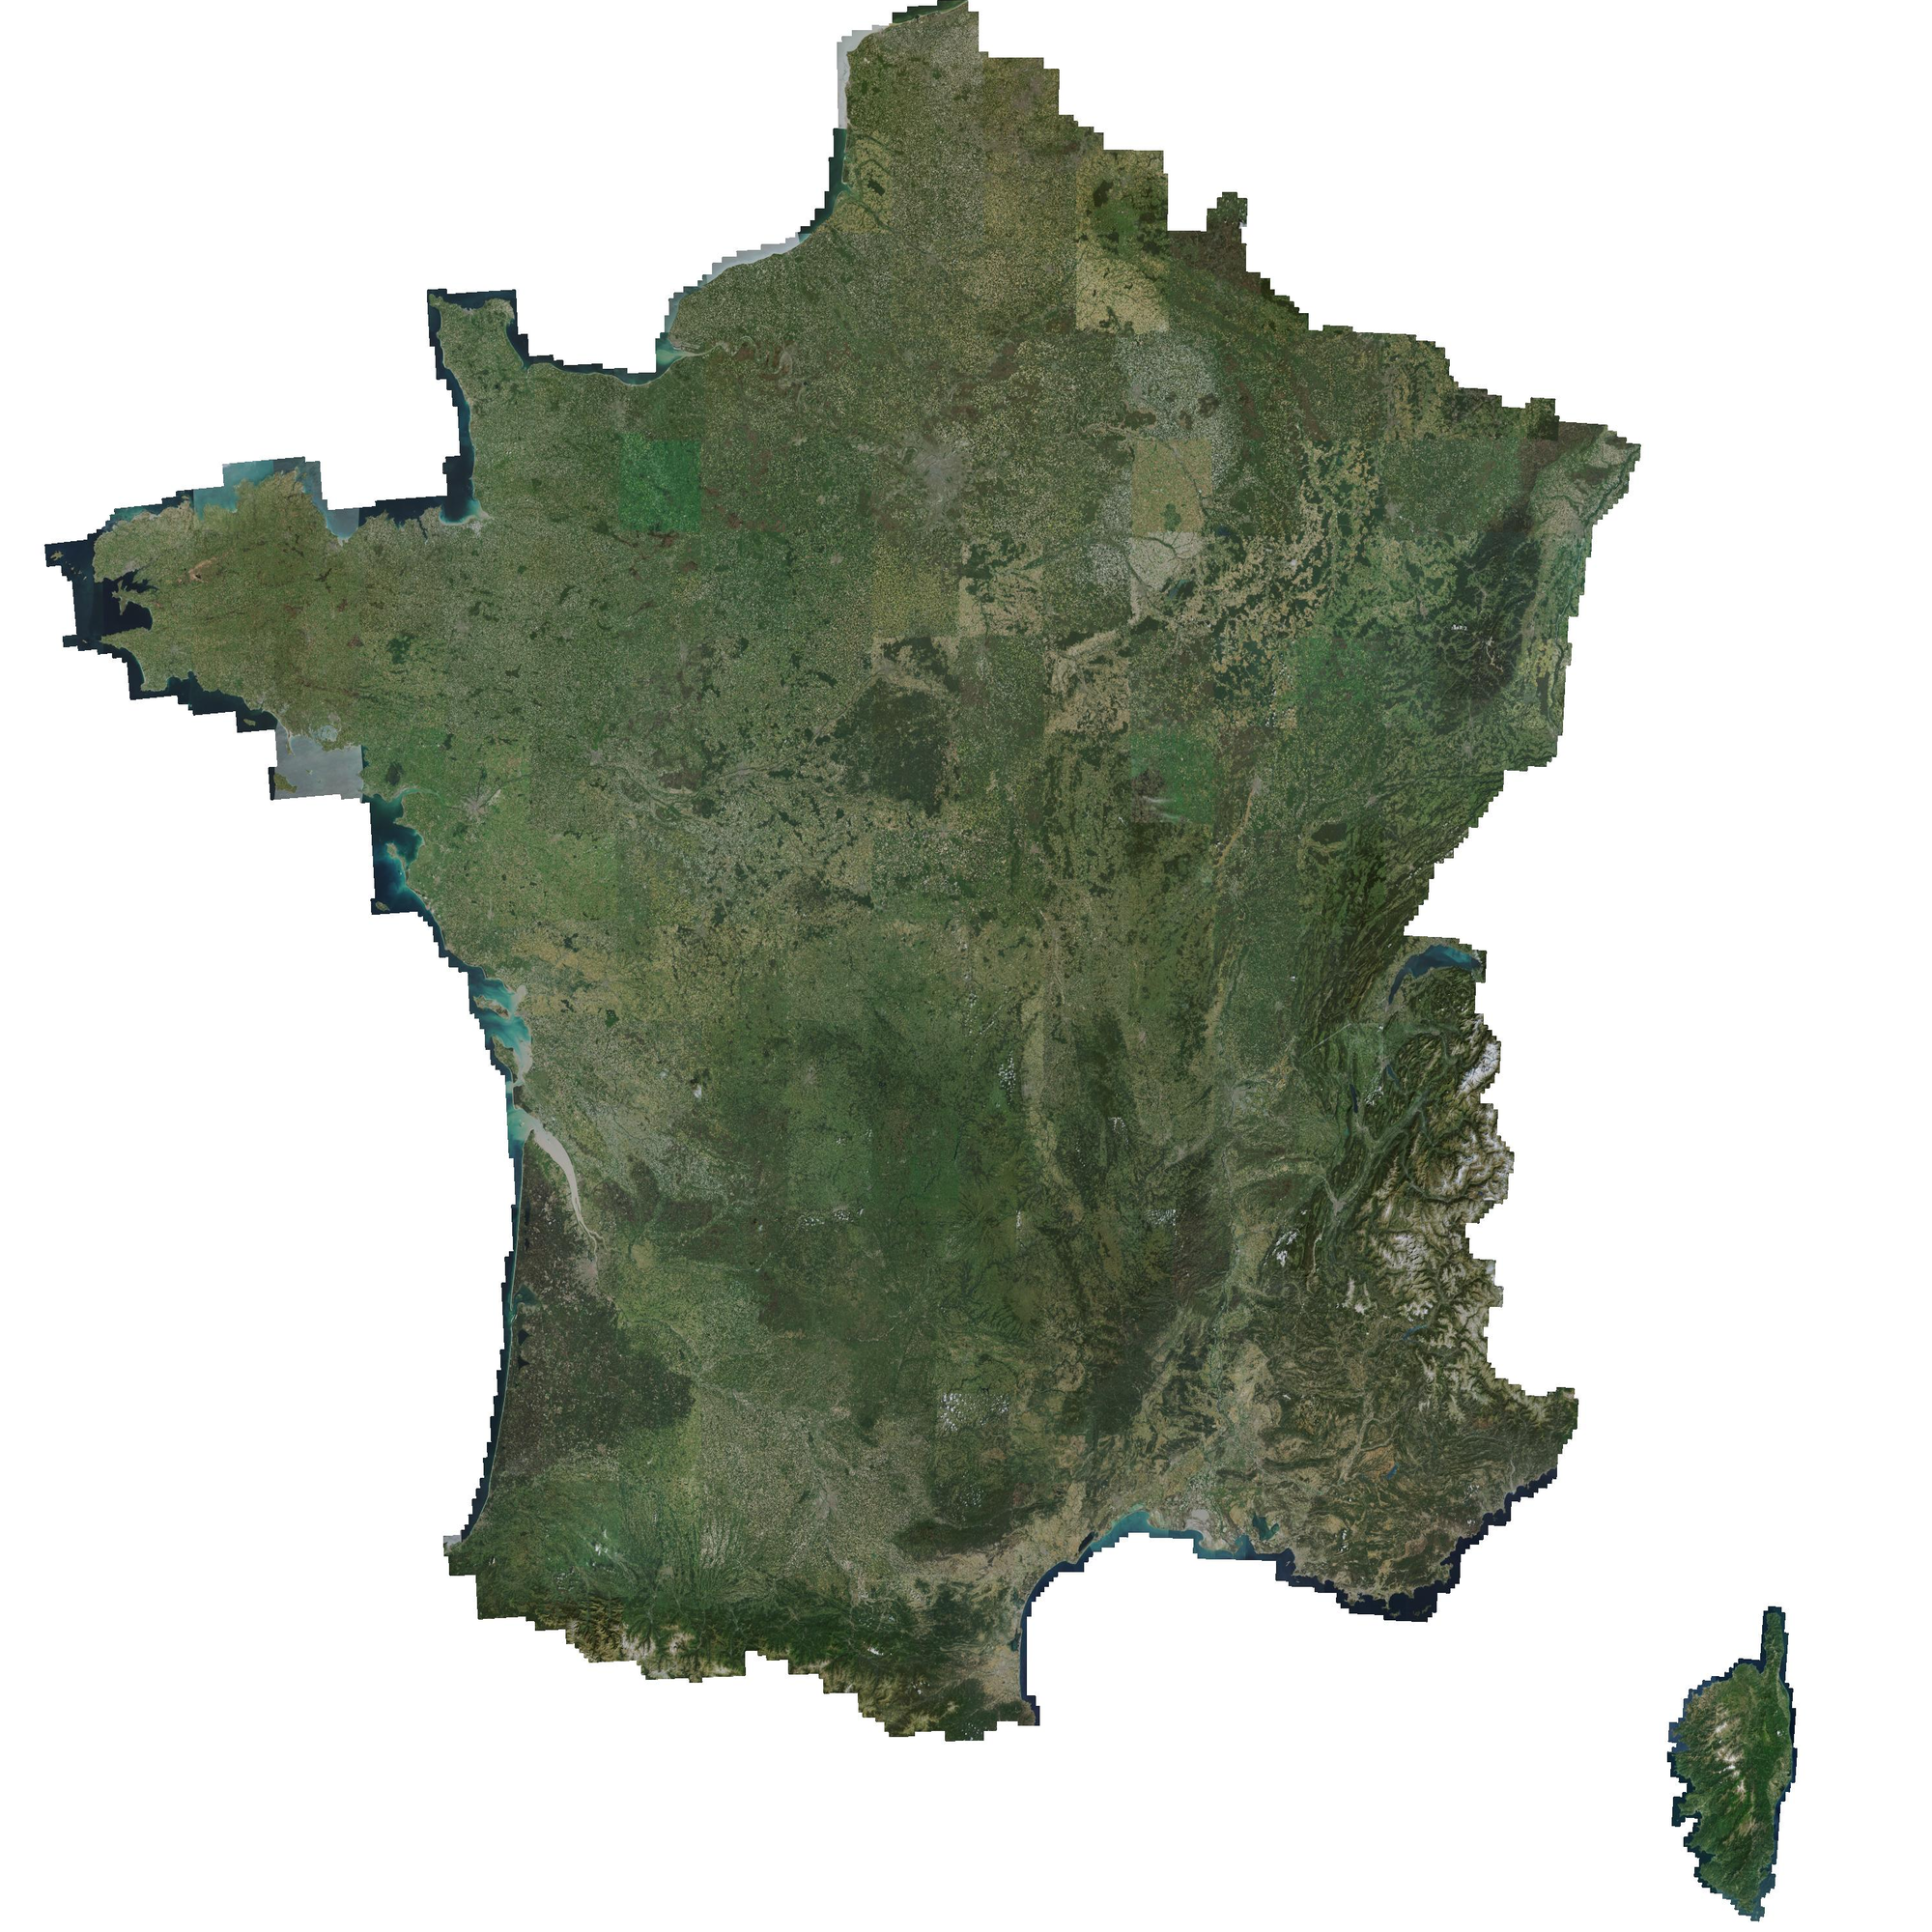

In [8]:
img = wms.getmap(layers=['ORTHOIMAGERY.ORTHO-SAT.SPOT.2021'],
                styles=['normal'],
                bbox = layer.boundingBox[0:4],
                # Left, bottom, right, top
                # bbox =(-220163.801503544, 2050671.178294608, 195507.700339527, 1641180.194057136),
                # srs='EPSG:2154',
                # srs = layer.boundingBox[4],
                srs = "EPSG:3857",
                # bbox=(-112, 36, -106, 41),
                # bbox = (-20, 20, -20, 20),
                size=(2000, 2000),
                format='image/png',
                transparent=True
)

Image(img.read())

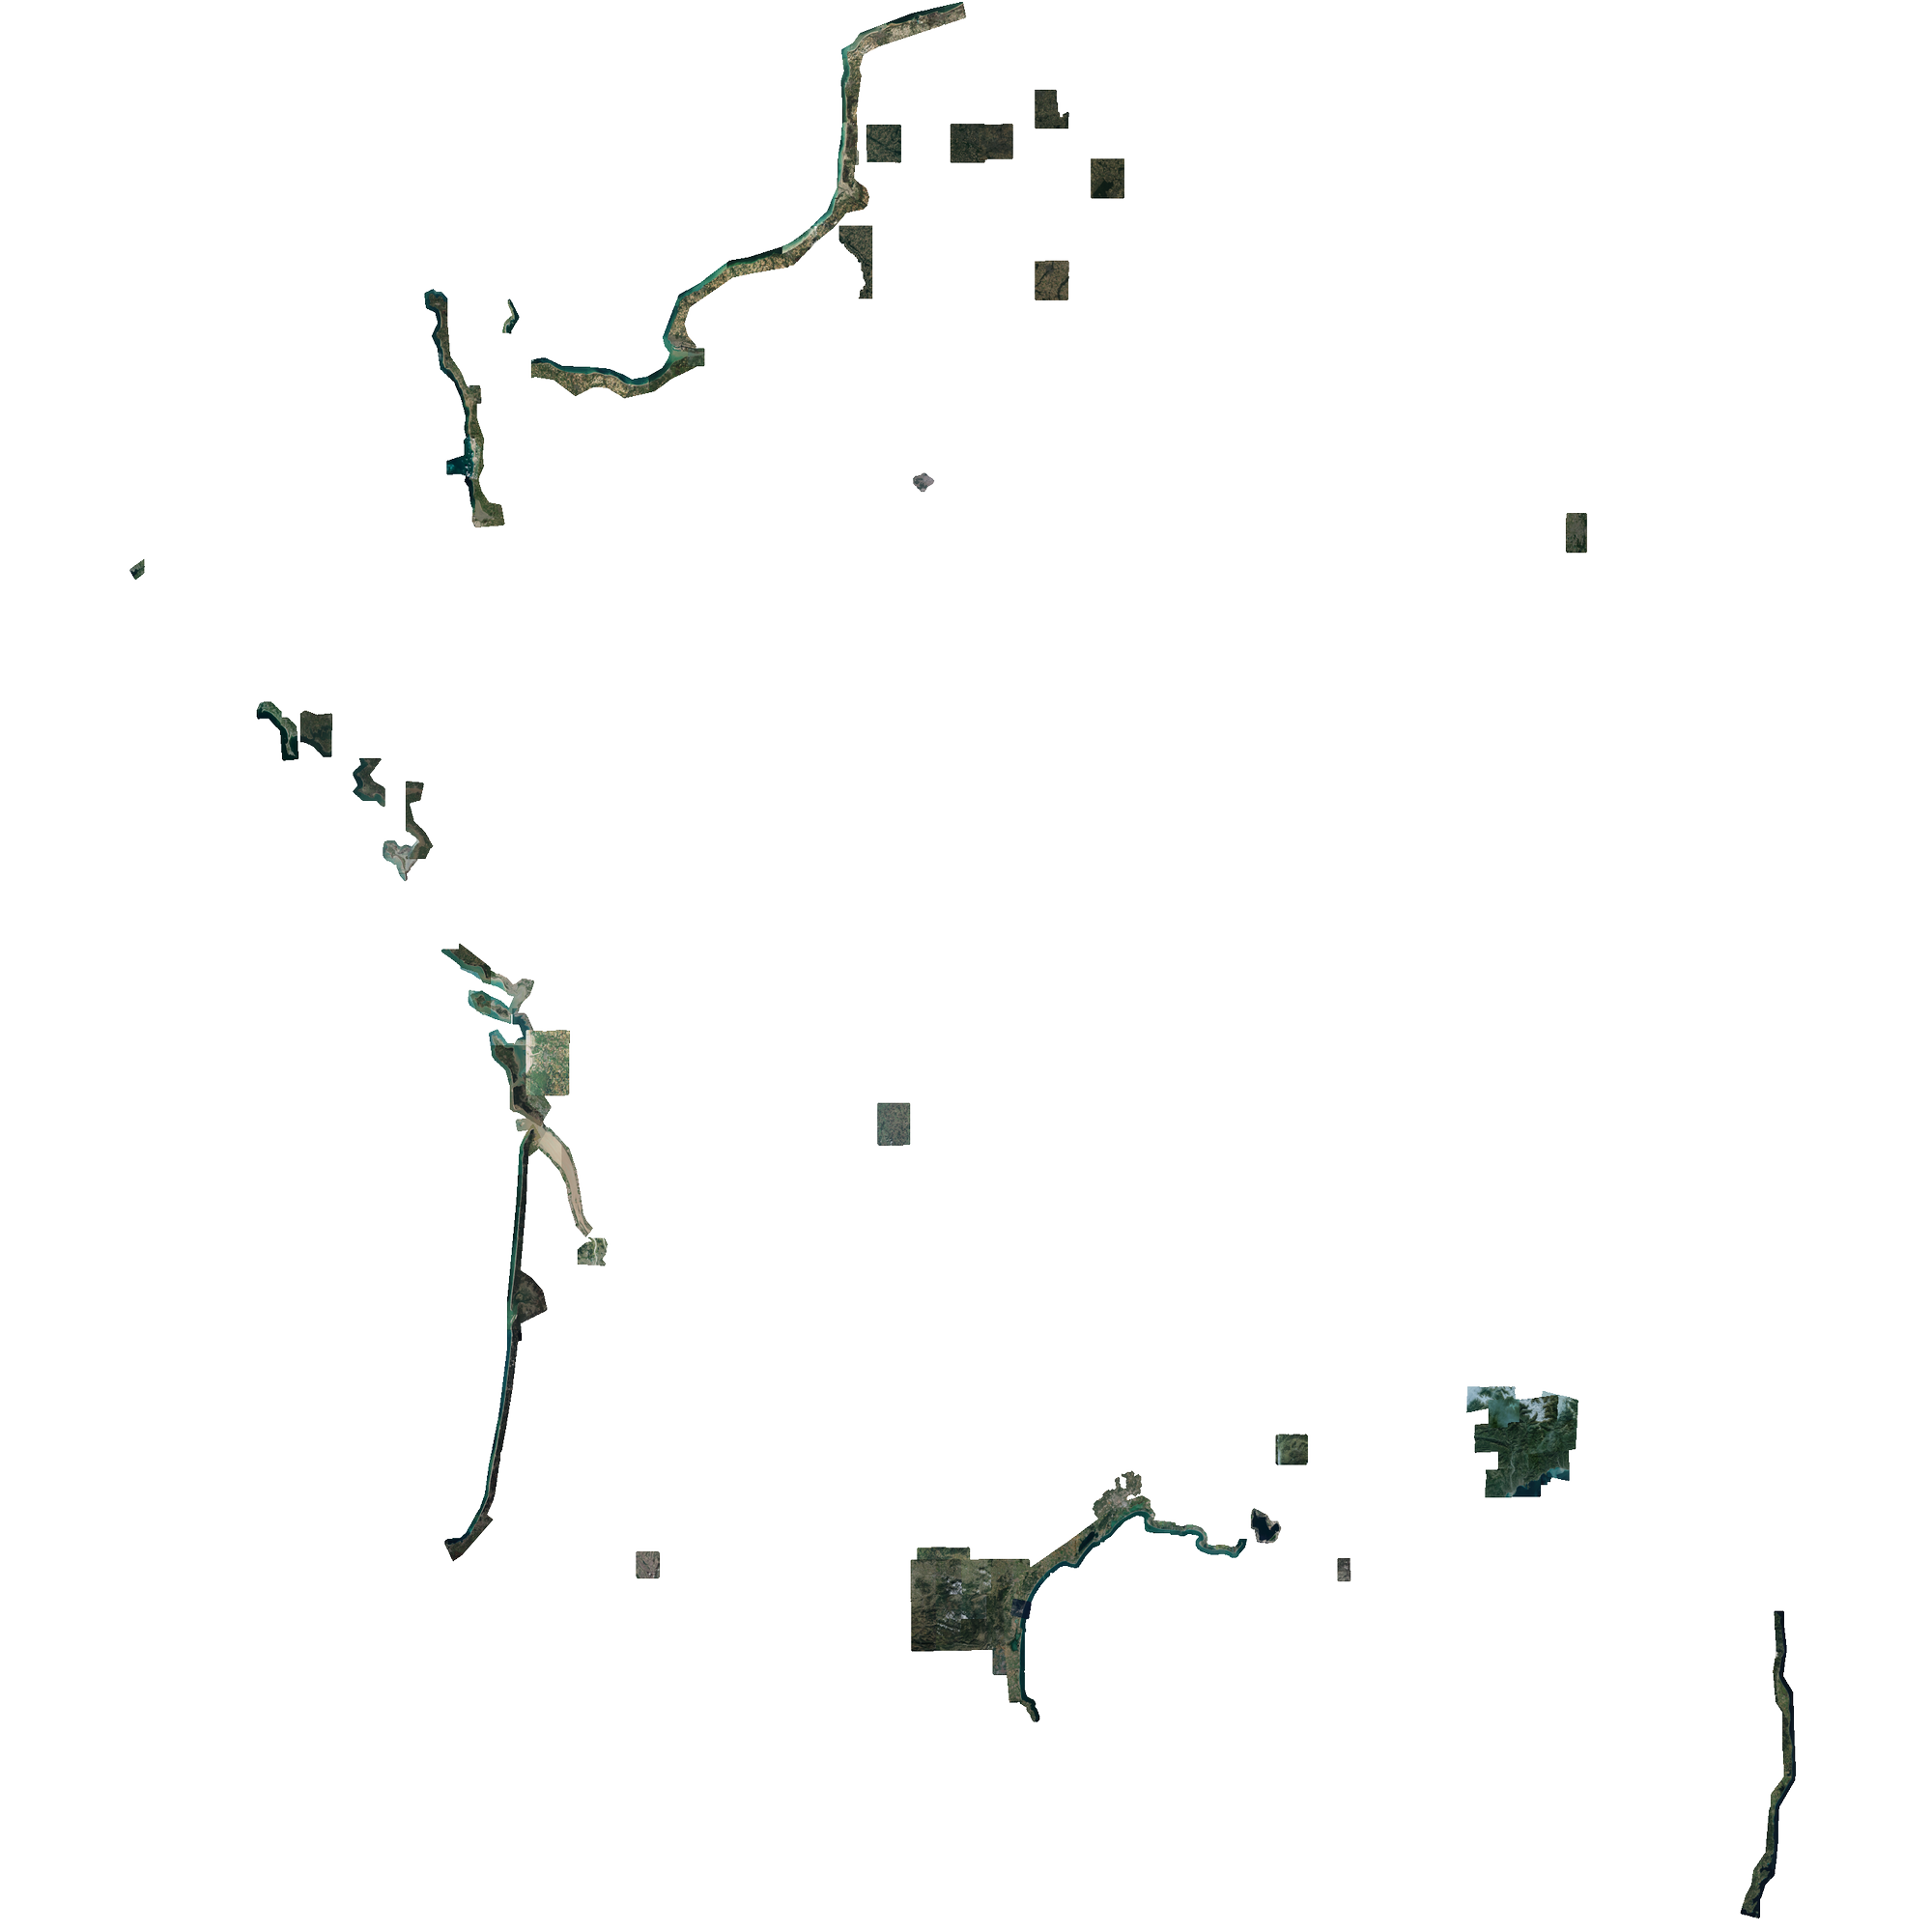

In [12]:
img = wms.getmap(layers=['ORTHOIMAGERY.ORTHO-SAT.PLEIADES.2020'],
                # styles=['normal'],
                bbox = layer.boundingBox[0:4],
                # Left, bottom, right, top
                # bbox =(-220163.801503544, 2050671.178294608, 195507.700339527, 1641180.194057136),
                # srs='EPSG:2154',
                srs = layer.boundingBox[4],
                # srs = "ESPG:4258",
                # bbox=(-112, 36, -106, 41),
                # bbox = (-20, 20, -20, 20),
                size=(2000, 2000),
                format='image/png',
                transparent=True
)

Image(img.read())

In [35]:
with open('test_img.png', 'wb') as outfile:
    outfile.write(img.read())